In [4]:
import torch
import torchvision.transforms as transforms
import numpy as np
from simclr import SimCLR
from torchvision import transforms

# Capsule Network
from capsule_network import resnet20
from norb import smallNORB
# ref https://discuss.pytorch.org/t/difference-between-torch-manual-seed-and-torch-cuda-manual-seed/13848/7
seed_value = 42
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `pytorch` pseudo-random generator at a fixed value
import torch
torch.manual_seed(seed_value)


Load the test loader

In [5]:
def get_test_loader(data_dir,
                    dataset,
                    batch_size, 
                    num_workers=4,
                    pin_memory=False):

    data_dir = data_dir + '/' + dataset

    from torchvision.transforms import InterpolationMode
    if dataset == "smallNorb":
        trans = [
                transforms.Resize(48, interpolation=InterpolationMode.BICUBIC),
                transforms.CenterCrop(32),
                transforms.ToTensor(),
                 ]
        dataset = smallNORB(data_dir, train=False, download=True,
                                transform=transforms.Compose(trans))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    print("type of test_loader", type(data_loader))
    print("Length of test_loader", len(data_loader))
    return data_loader


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': False}

# now we import testing dataset
batch_size = 64
test_loader = get_test_loader("./data", "smallNorb", batch_size, **kwargs)
num_test = len(test_loader.dataset)
print("Length of testing dataset", num_test)

# initialize ResNet
from simclr.modules.resnet_hacks import modify_resnet_model
from simclr.modules import get_resnet

encoder = get_resnet("resnet18", pretrained=False)
modified_resnet = modify_resnet_model(encoder)
capsule_network = resnet20(16, {'size': 32, 'channels': 3, 'classes': 10}, 32, 16, 1, mode="SR").to(device)

# initialize model
model = SimCLR(encoder, capsule_network)
checkpoint = torch.load("checkpoints/SR_simclr_fine_tune_after_pretrained_ckpt_epoch_20.tar", map_location=device)  
model.load_state_dict(checkpoint['model_state'], strict=True)
model = model.to(device)
model = model.eval()


type of test_loader <class 'torch.utils.data.dataloader.DataLoader'>
Length of test_loader 760
Length of testing dataset 48600


In [7]:
import torch
import json
# all of our models had 32 capsules
num_capsules = 32
# initialise them as 0
accumulated_activations = torch.zeros(num_capsules, device=device)

# Counter for the number of validation samples
num_samples = 0

for i, (x, y) in enumerate(test_loader):
    x = x.to(device) 
    with torch.no_grad(): 
        out = model(x)
    # Sum activations across the spatial dimensions for each capsule
    # and accumulate these sums across all validation samples
    accumulated_activations += torch.sum(out, dim=[0, 2, 3])
    # count the batches that have been processed
    num_samples += x.size(0)

# our activations are 4x4 (check the resnet file for more)
# so we divide by 16 to get the average activation per capsule element
average_activations = accumulated_activations / (num_samples * 16)  

average_activations_list = average_activations.cpu().tolist()

# Sanity checks
print("num_samples", num_samples)
print("accumulated_activations", accumulated_activations)
print("Average activations per capsule element:", average_activations_list)

# Save them to a JSON file for proof
data_to_save = {
    "capsule_averages": average_activations_list
}
file_path = 'capsules_averages/SR_fine_tune_capsule_averages_all.json'
with open(file_path, 'w') as f:
    json.dump(data_to_save, f, indent=4)

print(f"Saved activations averages to {file_path}")

num_samples 48600
accumulated_activations tensor([  166.4896,   123.3823,   171.5159,   114.6258,  1884.1628, 10908.6533,
        20768.5781,  5132.9863,   172.6366,   228.6144,   174.5298,   124.6120,
          170.3529,  7414.9209,  4415.2905,   107.3856, 18461.4277,   113.3427,
         1396.8431,   135.2104,  7218.8594, 19302.8086,   150.8821,  6137.0205,
          173.0535,   169.8722,   171.0140, 19791.8223,   146.8832,   175.1943,
          171.8833,  9646.1445], device='cuda:0')
Average activations per capsule element: [0.00021410702902358025, 0.00015867067850194871, 0.00022057087335269898, 0.0001474097225582227, 0.0024230489507317543, 0.014028618112206459, 0.026708561927080154, 0.006601062603294849, 0.0002220121241407469, 0.0002940000267699361, 0.00022444680507760495, 0.00016025204968173057, 0.0002190752129536122, 0.009535648860037327, 0.005678100045770407, 0.000138098796014674, 0.023741548880934715, 0.0001457596372347325, 0.001796351745724678, 0.00017388163541909307, 0.009283

Convert to a List for easier process

In [8]:
values_list = []
for value in data_to_save.values():
    values_list.extend(value)  
print("Flattened list of values:", values_list)

Flattened list of values: [0.00021410702902358025, 0.00015867067850194871, 0.00022057087335269898, 0.0001474097225582227, 0.0024230489507317543, 0.014028618112206459, 0.026708561927080154, 0.006601062603294849, 0.0002220121241407469, 0.0002940000267699361, 0.00022444680507760495, 0.00016025204968173057, 0.0002190752129536122, 0.009535648860037327, 0.005678100045770407, 0.000138098796014674, 0.023741548880934715, 0.0001457596372347325, 0.001796351745724678, 0.00017388163541909307, 0.009283512830734253, 0.024823570623993874, 0.00019403561600483954, 0.00789225846529007, 0.00022254818759392947, 0.00021845709125045687, 0.00021992536494508386, 0.025452446192502975, 0.00018889299826696515, 0.00022530135174747556, 0.0002210433012805879, 0.012405021116137505]


round to 2 decimals as per the literature
https://arxiv.org/abs/2305.11178

In [9]:
avg = [round(num, 2) for num in values_list]
avg

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.03,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.01,
 0.0,
 0.02,
 0.0,
 0.0,
 0.0,
 0.01,
 0.02,
 0.0,
 0.01,
 0.0,
 0.0,
 0.0,
 0.03,
 0.0,
 0.0,
 0.0,
 0.01]

Visualisation

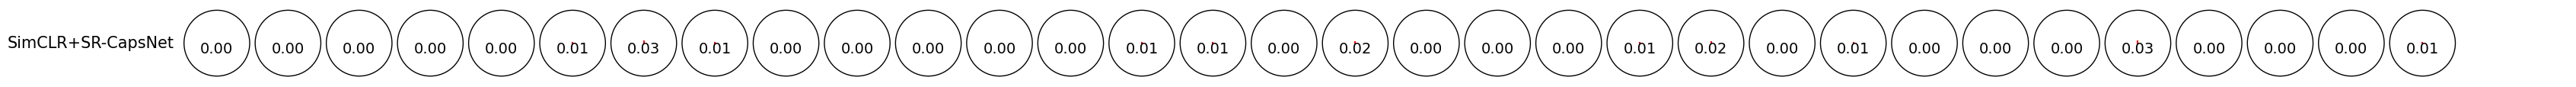

In [10]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

activations = avg 

fig, ax = plt.subplots(figsize=(34, 2.8))

# this is the space between circles
space_between_circles = 0.3 

# I make a circle for each capsule
for i, activation in enumerate(activations):
    circle_center = i * (1 + space_between_circles) + 1  
    circle = plt.Circle((circle_center, 0), 0.6, color='black', fill=False)
    ax.add_patch(circle)
    ax.plot([circle_center, circle_center], [0, activation], color='red')  
    ax.text(circle_center, -0.1, f'{activation:.2f}', ha='center', va='center', fontsize=14)

# add the name before the capsules at left 
ax.text(-1.3, 0, 'SimCLR+SR-CapsNet', ha='center', va='center', fontsize=15)
ax.set_aspect('equal')
ax.axis('off')

# save into pdf for higher quality
plt.tight_layout()
plt.savefig('graphs_for_thesis/simclr_sr_smallnorb_fine_tune.pdf', format='pdf')  
plt.show()